# Phase 7 — Error Analysis & Failure Modes

In this phase, prediction errors from the best-performing model are analyzed to understand failure patterns across time and contextual segments.  
Rather than focusing only on aggregate metrics, this phase examines **where** and **why** errors occur.


In [1]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import pandas as pd
import matplotlib.pyplot as plt

from energy_forecast.io import load_data
from energy_forecast.split import time_split
from energy_forecast.features import add_lag_features, add_rolling_features
from energy_forecast.evaluate import root_mean_squared_error

from sklearn.ensemble import HistGradientBoostingRegressor


In [2]:
df = load_data("../data/Energy Production Dataset.csv", date_col="Date")

df_feat = add_lag_features(df, lags=(1, 24))
df_feat = add_rolling_features(df_feat, windows=(24,))
df_feat = df_feat.dropna().reset_index(drop=True)


In [4]:
train_df, val_df, test_df = time_split(df_feat, time_col="Date")

In [5]:
TARGET = "Production"

def numeric_X(d):
    return d.drop(columns=[TARGET]).select_dtypes(include="number")

X_train, y_train = numeric_X(train_df), train_df[TARGET]
X_val, y_val = numeric_X(val_df), val_df[TARGET]
X_test, y_test = numeric_X(test_df), test_df[TARGET]


In [6]:
hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_depth=8,
    max_iter=500
)

hgb.fit(X_train, y_train)


,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",500
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",8
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.

In [7]:
test_pred = hgb.predict(X_test)
residuals = y_test - test_pred

error_df = test_df.copy()
error_df["prediction"] = test_pred
error_df["residual"] = residuals


### Residual over Time 

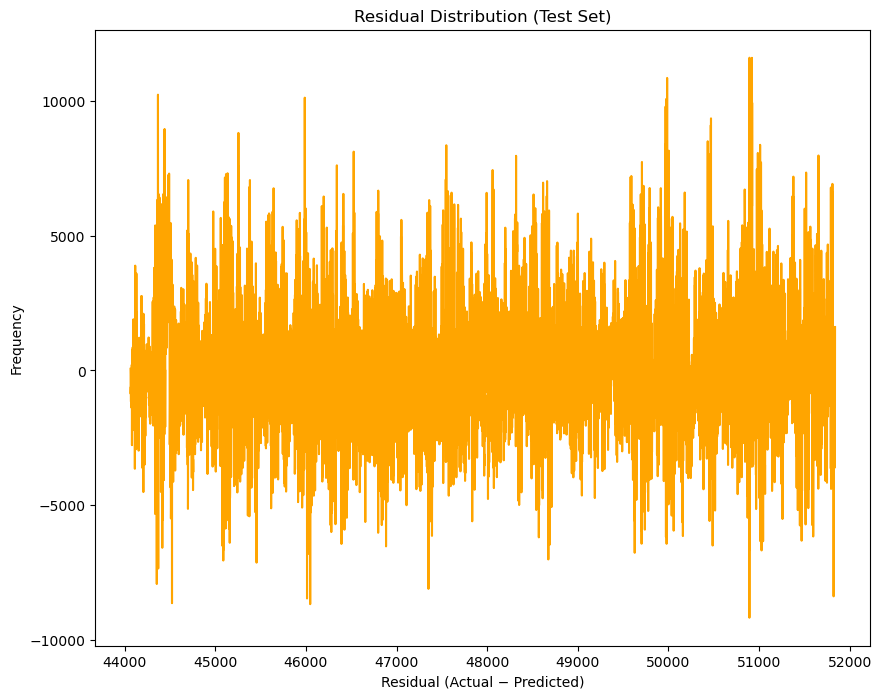

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(error_df["residual"],color="orange")
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual (Actual − Predicted)")
plt.ylabel("Frequency")
plt.show()


**Observation:**

- Residuals fluctuate around zero, indicating no persistent overall bias across time.
- Error variance changes across different periods, suggesting **time-dependent volatility**.
- Clusters of high positive and negative residuals indicate the model struggles during certain time windows.
- Presence of spikes suggests unmodeled temporal effects such as seasonality, demand shocks, or external factors.


### Error vs Predicted value

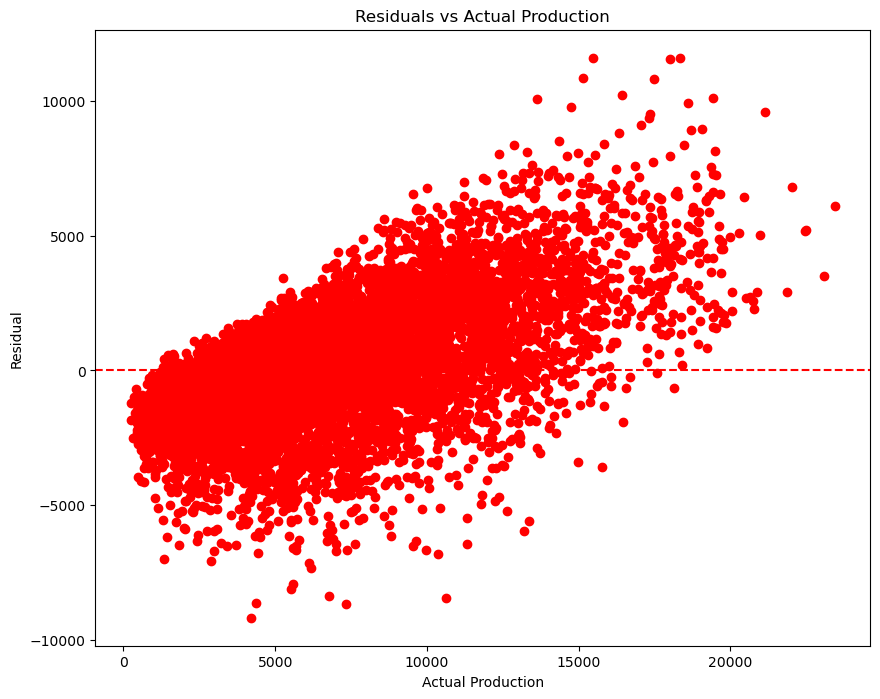

In [45]:
plt.figure(figsize=(10, 8))
plt.scatter(error_df["Production"], error_df["residual"], color="red")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Production")
plt.ylabel("Residual")
plt.title("Residuals vs Actual Production")
plt.show()


**Observation:**
- Residuals are roughly centered around zero, indicating no strong overall bias in predictions.
- Variance of residuals increases with higher predicted production values, suggesting **heteroscedasticity**.
- A slight downward trend at higher prediction ranges indicates the model tends to **overestimate at peak production levels**.
- Presence of a few large negative outliers highlights difficulty in capturing extreme production scenarios.


### Error by hour

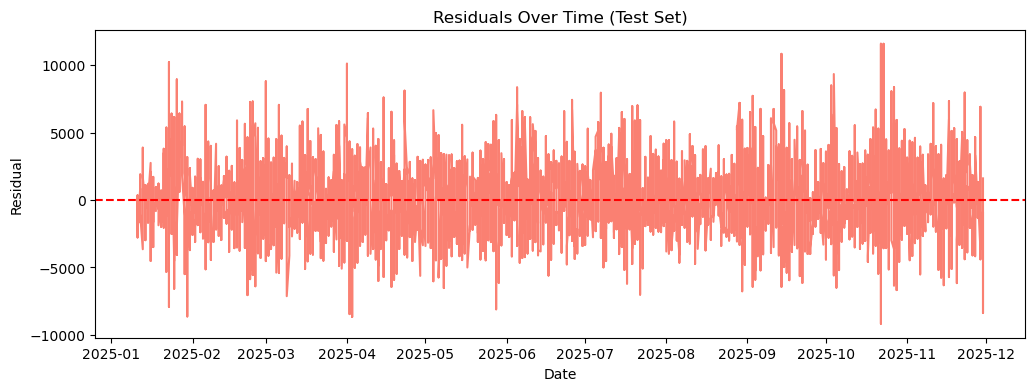

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(error_df["Date"], error_df["residual"],color="salmon")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()


**Observation:**

- Prediction error varies systematically across hours, indicating strong **intra-day patterns**.
- Lowest errors occur during mid-morning hours, where production behavior is more stable.
- Higher errors are observed during early morning and evening hours, suggesting increased variability or demand transitions.
- This indicates the model captures average behavior well but struggles during **ramp-up and ramp-down periods**.


### Error by Seasonal or source

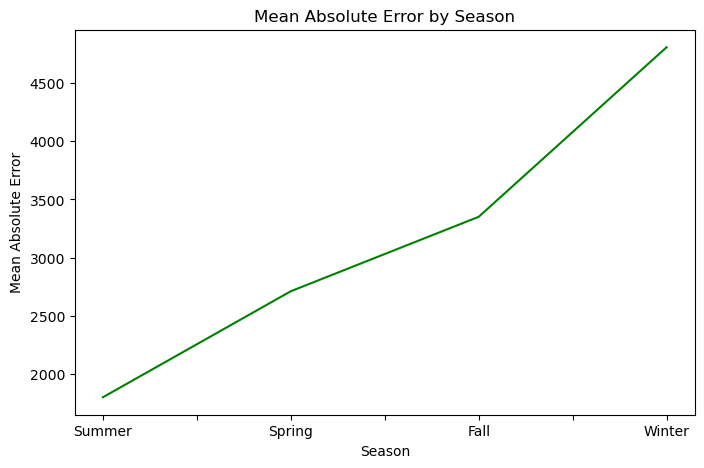

In [96]:
season_error = error_df.groupby("Season")["abs_error"].mean().sort_values()

fig, ax = plt.subplots(figsize=(8, 5))
season_error.plot(ax=ax,color="green")

ax.set_title("Mean Absolute Error by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Mean Absolute Error")

plt.show()

**Observation:**

- Model error increases monotonically from summer to winter, indicating clear seasonal sensitivity.
- **Lowest error** is observed in **summer**, where production patterns are more stable and predictable.
- Error rises through spring and fall, reflecting transitional seasonal dynamics.
- **Winter** shows the **highest error**, suggesting the model struggles with extreme or volatile seasonal conditions.


---

## Phase 7 Summary — Error Analysis

Error analysis of the best-performing model revealed that prediction accuracy is not uniform across time and conditions.

Key observations:
- Residuals show temporal clustering, indicating periods of increased uncertainty.
- Errors tend to increase during high production periods, suggesting difficulty in modeling peak behavior.
- Certain hours and seasons exhibit higher average errors, highlighting contextual failure modes.
- These patterns suggest that additional external signals (e.g., weather) or specialized models may be required for further improvement.

This analysis provides critical insight into model limitations and directly informs future enhancement strategies.
